
<a id='wald-friedman'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# A Problem that Stumped Milton Friedman

(and that Abraham Wald solved by inventing sequential analysis)


<a id='index-1'></a>

## Contents

- [A Problem that Stumped Milton Friedman](#A-Problem-that-Stumped-Milton-Friedman)  
  - [Overview](#Overview)  
  - [Origin of the problem](#Origin-of-the-problem)  
  - [A dynamic programming approach](#A-dynamic-programming-approach)  
  - [Implementation](#Implementation)  
  - [Comparison with Neyman-Pearson formulation](#Comparison-with-Neyman-Pearson-formulation)  

Co-authored with Chase Coleman

## Overview

This lecture describes a statistical decision problem encountered  by Milton Friedman and W. Allen Wallis during World War II when they were analysts at the U.S. Government’s  Statistical Research Group at Columbia University.

This problem led Abraham Wald [[Wal47]](../zreferences.html#wald47) to formulate **sequential analysis**, an approach to statistical decision problems intimately related to dynamic programming.

In this lecture, we apply dynamic programming algorithms to Friedman and Wallis and Wald’s problem.

Key ideas in play will be:

- Bayes’ Law  
- Dynamic programming  
- Type I and type II statistical errors  
  - a type I error occurs when you reject a null hypothesis that is true  
  - a type II error is when you accept a null hypothesis that is false  
- Abraham Wald’s **sequential probability ratio test**  
- The **power** of a statistical test  
- The **critical region** of a statistical test  
- A **uniformly most powerful test**  

## Origin of the problem

On pages 137-139 of his 1998 book *Two Lucky People* with Rose Friedman [[FF98]](../zreferences.html#friedman98),
Milton Friedman described a problem presented to him and Allen Wallis
during World War II, when they worked at the US Government’s
Statistical Research Group at Columbia University.

Let’s listen to Milton Friedman tell us what happened.

“In order to understand the story, it is necessary to have an idea of a
simple statistical problem, and of the standard procedure for dealing
with it. The actual problem out of which sequential analysis grew will
serve. The Navy has two alternative designs (say A and B) for a
projectile. It wants to determine which is superior. To do so it
undertakes a series of paired firings. On each round it assigns the
value 1 or 0 to A accordingly as its performance is superior or inferior
to that of B and conversely 0 or 1 to B. The Navy asks the statistician
how to conduct the test and how to analyze the results.

“The standard statistical answer was to specify a number of firings (say
1,000) and a pair of percentages (e.g., 53% and 47%) and tell the client
that if A receives a 1 in more than 53% of the firings, it can be
regarded as superior; if it receives a 1 in fewer than 47%, B can be
regarded as superior; if the percentage is between 47% and 53%, neither
can be so regarded.

“When Allen Wallis was discussing such a problem with (Navy) Captain
Garret L. Schyler, the captain objected that such a test, to quote from
Allen’s account, may prove wasteful. If a wise and seasoned ordnance
officer like Schyler were on the premises, he would see after the first
few thousand or even few hundred [rounds] that the experiment need not
be completed either because the new method is obviously inferior or
because it is obviously superior beyond what was hoped for
$ \ldots $ ‘’

Friedman and Wallis struggled with the problem but, after realizing that
they were not able to solve it,  described the problem to  Abraham Wald.

That started Wald on the path that led him  to *Sequential Analysis* [[Wal47]](../zreferences.html#wald47).

We’ll formulate the problem using dynamic programming.

## A dynamic programming approach

The following presentation of the problem closely follows Dmitri
Berskekas’s treatment in **Dynamic Programming and Stochastic Control** [[Ber75]](../zreferences.html#bertekas75).

A decision maker observes iid draws of a random variable $ z $.

He (or she) wants to know which of two probability distributions $ f_0 $ or $ f_1 $ governs $ z $.

After a number of draws, also to be determined, he makes a decision as to which of the distributions is generating the draws he observers.

To help formalize the problem, let $ x \in \{x_0, x_1\} $ be a hidden state that indexes the two distributions:

$$
\mathbb P\{z = v \mid x \}
= \begin{cases}
    f_0(v) & \mbox{if } x = x_0, \\
    f_1(v) & \mbox{if } x = x_1
\end{cases}
$$

Before observing any outcomes, the decision maker believes that the probability that $ x = x_0 $ is

$$
p_{-1} =
\mathbb P \{ x=x_0 \mid \textrm{ no observations} \} \in (0, 1)
$$

After observing $ k+1 $ observations $ z_k, z_{k-1}, \ldots, z_0 $, he updates this value to

$$
p_k = \mathbb P \{ x = x_0 \mid z_k, z_{k-1}, \ldots, z_0 \},
$$

which is calculated recursively by applying Bayes’ law:

$$
p_{k+1} = \frac{ p_k f_0(z_{k+1})}{ p_k f_0(z_{k+1}) + (1-p_k) f_1 (z_{k+1}) },
\quad k = -1, 0, 1, \ldots
$$

After observing $ z_k, z_{k-1}, \ldots, z_0 $, the decision maker believes that $ z_{k+1} $ has probability distribution

$$
f(v) = p_k f_0(v) + (1-p_k) f_1 (v)
$$

This is a mixture of distributions $ f_0 $ and $ f_1 $, with the weight on $ f_0 $ being the posterior probability that $ x = x_0 $ <sup><a href=#f1 id=f1-link>[1]</a></sup>.

To help illustrate this kind of distribution, let’s inspect some mixtures of beta distributions.

The density of a beta probability distribution with parameters $ a $ and $ b $ is

$$
f(z; a, b) = \frac{\Gamma(a+b) z^{a-1} (1-z)^{b-1}}{\Gamma(a) \Gamma(b)}
\quad \text{where} \quad
\Gamma(t) := \int_{0}^{\infty} x^{t-1} e^{-x} dx
$$

We’ll discretize this distribution to make it more straightforward to work with.

The next figure shows two discretized beta distributions in the top panel.

The bottom panel presents mixtures of these distributions, with various mixing probabilities $ p_k $.

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.6.0")
# uncomment to force package installation and precompilation
# github_project("QuantEcon/quantecon-notebooks-julia", version="0.6.0", instantiate=true, precompile = true)

In [2]:
using LinearAlgebra, Statistics
using Distributions, Parameters, Printf, Random, Roots, Plots

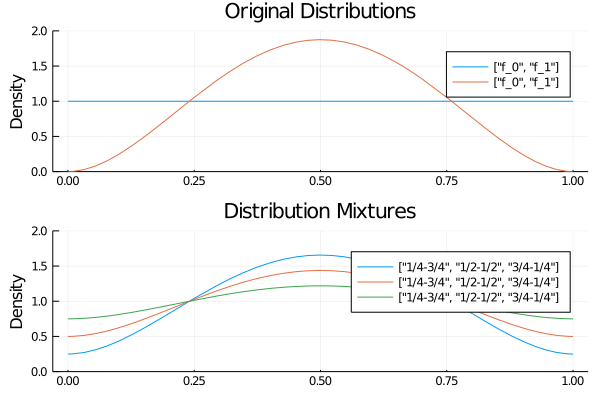

In [3]:
using StatsPlots

begin
    base_dist = [Beta(1, 1), Beta(3, 3)]
    mixed_dist = MixtureModel.(Ref(base_dist), (p -> [p, one(p) - p]).(0.25:0.25:0.75))
    plot(plot(base_dist, labels = ["f_0", "f_1"], title = "Original Distributions"),
         plot(mixed_dist, labels = ["1/4-3/4", "1/2-1/2", "3/4-1/4"],
              title = "Distribution Mixtures"),
         # Global settings across both plots
         ylab = "Density", ylim = (0, 2), layout = (2, 1)
         )
end

### Losses and costs

After observing $ z_k, z_{k-1}, \ldots, z_0 $, the decision maker
chooses among three distinct actions:

- He decides that $ x = x_0 $ and draws no more $ z $’s.  
- He decides that $ x = x_1 $ and draws no more $ z $’s.  
- He postpones deciding now and instead chooses to draw a
  $ z_{k+1} $.  


Associated with these three actions, the decision maker can suffer three
kinds of losses:

- A loss $ L_0 $ if he decides $ x = x_0 $ when actually
  $ x=x_1 $.  
- A loss $ L_1 $ if he decides $ x = x_1 $ when actually
  $ x=x_0 $.  
- A cost $ c $ if he postpones deciding and chooses instead to draw
  another $ z $.  

### Digression on type I and type II errors

If we regard  $ x=x_0 $ as a null hypothesis and $ x=x_1 $ as an alternative hypothesis,
then $ L_1 $ and $ L_0 $ are losses associated with two types of statistical errors.

- a type I error is an incorrect rejection of a true null hypothesis (a “false positive”)  
- a type II error is a failure to reject a false null hypothesis (a “false negative”)  


So when we treat $ x=x_0 $ as the null hypothesis

- We can think of $ L_1 $ as the loss associated with a type I
  error.  
- We can think of $ L_0 $ as the loss associated with a type II
  error.  

### Intuition

Let’s try to guess what an optimal decision rule might look like before we go further.

Suppose at some given point in time that $ p $ is close to 1.

Then our prior beliefs and the evidence so far point strongly to $ x = x_0 $.

If, on the other hand, $ p $ is close to 0, then $ x = x_1 $ is strongly favored.

Finally, if $ p $ is in the middle of the interval $ [0, 1] $, then we have little information in either direction.

This reasoning suggests a decision rule such as the one shown in the figure

<img src="_static/figures/wald_dec_rule.png" style="width:50%;">

  
As we’ll see, this is indeed the correct form of the decision rule.

The key problem is to determine the threshold values $ \alpha, \beta $,
which will depend on the parameters listed above.

You might like to pause at this point and try to predict the impact of a
parameter such as $ c $ or $ L_0 $ on $ \alpha $ or $ \beta $.

### A Bellman equation

Let $ J(p) $ be the total loss for a decision maker with current belief $ p $ who chooses optimally.

With some thought, you will agree that $ J $ should satisfy the Bellman equation


<a id='equation-new1'></a>
$$
J(p) =
    \min
    \left\{
        (1-p) L_0, \; p L_1, \;
        c + \mathbb E [ J (p') ]
    \right\} \tag{1}
$$

where $ p' $ is the random variable defined by


<a id='equation-wf-new2'></a>
$$
p' = \frac{ p f_0(z)}{ p f_0(z) + (1-p) f_1 (z) } \tag{2}
$$

when $ p $ is fixed and $ z $ is drawn from the current best guess, which is the distribution $ f $ defined by


<a id='equation-wf-new3'></a>
$$
f(v) = p f_0(v) + (1-p) f_1 (v) \tag{3}
$$

In the Bellman equation, minimization is over three actions:

1. accept $ x_0 $  
1. accept $ x_1 $  
1. postpone deciding and draw again  


Let


<a id='equation-new4'></a>
$$
A(p)
:= \mathbb E [ J (p') ] \tag{4}
$$

Then we can represent the  Bellman equation as


<a id='equation-new5'></a>
$$
J(p) =
\min \left\{ (1-p) L_0, \; p L_1, \; c + A(p) \right\} \tag{5}
$$

where $ p \in [0,1] $.

Here

- $ (1-p) L_0 $ is the expected loss associated with accepting
  $ x_0 $ (i.e., the cost of making a type II error).  
- $ p L_1 $ is the expected loss associated with accepting
  $ x_1 $ (i.e., the cost of making a type I error).  
- $ c + A(p) $ is the expected cost associated with drawing one more $ z $.  


The optimal decision rule is characterized by two numbers $ \alpha, \beta \in (0,1) \times (0,1) $ that satisfy


<a id='equation-new6'></a>
$$
(1- p) L_0 < \min \{ p L_1, c + A(p) \}  \textrm { if } p \geq \alpha \tag{6}
$$

and


<a id='equation-new7'></a>
$$
p L_1 < \min \{ (1-p) L_0,  c + A(p) \} \textrm { if } p \leq \beta \tag{7}
$$

The optimal decision rule is then


<a id='equation-new8'></a>
$$
\begin{aligned}
\textrm { accept } x=x_0 \textrm{ if } p \geq \alpha \\
\textrm { accept } x=x_1 \textrm{ if } p \leq \beta \\
\textrm { draw another }  z \textrm{ if }  \beta \leq p \leq \alpha
\end{aligned} \tag{8}
$$

Our aim is to compute the value function $ J $, and from it the associated cutoffs $ \alpha $
and $ \beta $.

One sensible approach is to write the three components of $ J $
that appear on the right side of the Bellman equation as separate functions.

Later, doing this will help us obey **the don’t repeat yourself (DRY)** golden rule of coding.

## Implementation

Let’s code this problem up and solve it.

We implement the cost functions for each choice considered in the
Bellman equation [(7)](../dynamic_programming_squared/dyn_stack.html#equation-new3).

First, consider the cost associated to accepting either distribution and
compare the minimum of the two to the expected benefit of drawing again.

Drawing again will only be worthwhile if the expected marginal benefit of
learning from an additional draw is greater than the explicit cost.

For every belief $ p $, we can compute the difference between accepting a
distribution and choosing to draw again.

The solution $ \alpha $, $ \beta $ occurs at indifference points.

Define the cost function be the minimum of the pairwise differences in cost among
the choices.

Then we can find the indifference points when the cost function is zero.

We can use any roots finding algorithm to solve for the solutions in the
interval [0, 1].

Lastly, verify which indifference points correspond to the definition of a permanent
transition between the accept and reject space for each choice.

Here’s the code

In [4]:
accept_x0(p, L0) = (one(p) - p) * L0
accept_x1(p, L1) = p * L1
bayes_update(p, d0, d1) = p * pdf(d0, p) / pdf(MixtureModel([d0, d1], [p, one(p) - p]), p)
function draw_again(p, d0, d1, L0, L1, c, target)
    candidate = 0.0
    cost = 0.0
    while candidate < target
        p = bayes_update(p, d0, d1)
        cost += c
        candidate = min(accept_x0(p, L0), accept_x1(p, L1)) + cost
        if candidate >= target
            break
        end
        target = candidate
    end
    return candidate
end
function choice(p, d0, d1, L0, L1, c)
    if isone(p)
        output = (1, 0)
    elseif iszero(p)
        output = (2, 0)
    elseif zero(p) < p < one(p)
        target, option = findmin([accept_x0(p, L0), accept_x1(p, L1)])
        candidate = draw_again(p, d0, d1, L0, L1, c, target)
        if candidate < target
            target, option = (candidate, 3)
        end
        output = (option, target)
    else
        throw(ArgumentError("p must be ∈ [0, 1]"))
    end
    return output
end

choice (generic function with 1 method)

Next we solve a problem by finding the α, β values for the decision rule

In [5]:
function decision_rule(d0, d1, L0, L1, c)
    function cost(p, d0, d1, L0, L1, c)
        if c < zero(c)
            throw(ArgumentError("Cost must be non-negative"))
        end
        x0 = accept_x0(p, L0)
        x1 = accept_x1(p, L1)
        draw = draw_again(p, d0, d1, L0, L1, c, min(x0, x1))
        output = min(abs(draw - x0), abs(draw - x1), abs(x1 - x0))
        return output
    end
    # Find the indifference points
    roots = find_zeros(p -> cost(p, d0, d1, L0, L1, c), 0 + eps(), 1 - eps())
    # Compute the choice at both sides
    left = first.(choice.(roots .- eps(), d0, d1, L0, L1, c))
    right = first.(choice.(roots .+ eps(), d0, d1, L0, L1, c))
    # Find β by checking for a permanent transition from the area accepting to
    # x₁ to never again accepting x₁ at the various indifference points
    # Find α by checking for a permanent transition from the area accepting of
    # x₀ to never again accepting x₀ at the various indifference points
    β = findlast((left .== 2) .& (right .≠ 2)) |> (x -> isa(x, Int) ? roots[x] : 0)
    α = findfirst((left .≠ 1) .& (right .== 1)) |> (x -> isa(x, Int) ? roots[x] : 1)
    if β < α
        @printf("Accept x1 if p ≤ %.2f\nContinue to draw if %.2f ≤ p ≤ %.2f
                \nAccept x0 if p ≥ %.2f", β, β, α, α)
    else
        x0 = accept_x0(β, L0)
        x1 = accept_x1(β, L1)
        draw = draw_again(β, d0, d1, L0, L1, c, min(x0, x1))
        if draw == min(x0, x1, draw)
            @printf("Accept x1 if p ≤ %.2f\nContinue to draw if %.2f ≤ p ≤ %.2f
                    \nAccept x0 if p ≥ %.2f", β, β, α, α)
        else
            @printf("Accept x1 if p ≤ %.2f\nAccept x0 if p ≥ %.2f", β, α)
        end
    end
    return (α, β)
end

decision_rule (generic function with 1 method)

We can simulate an agent facing a problem and the outcome with the following function

In [6]:
function simulation(problem)
    @unpack d0, d1, L0, L1, c, p, n, return_output = problem
    α, β = decision_rule(d0, d1, L0, L1, c)
    outcomes = fill(false, n)
    costs = fill(0.0, n)
    trials = fill(0, n)
    for trial in 1:n
        # Nature chooses
        truth = rand(1:2)
        # The true distribution and loss are defined based on the truth
        d = (d0, d1)[truth]
        l = (L0, L1)[truth]
        t = 0
        choice = 0
        while iszero(choice)
            t += 1
            outcome = rand(d)
            p = bayes_update(p, d0, d1)
            if p <= β
                choice = 1
            elseif p >= α
                choice = 2
            end
        end
        correct = choice == truth
        cost = t * c + (correct ? 0 : l)
        outcomes[trial] = correct
        costs[trial] = cost
        trials[trial] = t
    end
    @printf("\nCorrect: %.2f\nAverage Cost: %.2f\nAverage number of trials: %.2f",
            mean(outcomes), mean(costs), mean(trials))
    return return_output ? (α, β, outcomes, costs, trials) : nothing
end

Problem = @with_kw (d0 = Beta(1,1), d1 = Beta(9,9),
                    L0 = 2, L1 = 2,
                    c = 0.2, p = 0.5,
                    n = 100, return_output = false);

In [7]:
Random.seed!(0);
simulation(Problem());

Accept x1 if p ≤ 0.35
Continue to draw if 0.35 ≤ p ≤ 0.57
                
Accept x0 if p ≥ 0.57
Correct: 0.43
Average Cost: 1.42
Average number of trials: 1.40

### Comparative statics

Now let’s consider the following exercise.

We double the cost of drawing an additional observation.

Before you look, think about what will happen:

- Will the decision maker be correct more or less often?  
- Will he make decisions sooner or later?  

In [8]:
Random.seed!(0);
simulation(Problem(c = 0.4));

Accept x1 if p ≤ 0.41
Continue to draw if 0.41 ≤ p ≤ 0.54
                
Accept x0 if p ≥ 0.54
Correct: 0.45
Average Cost: 1.59
Average number of trials: 1.22

Notice what happens?

The average number of trials decreased.

Increased cost per draw has induced the decision maker to decide in 0.18 less trials on average.

Because he decides with less experience, the percentage of time he is correct drops.

This leads to him having a higher expected loss when he puts equal weight on both models.

## Comparison with Neyman-Pearson formulation

For several reasons, it is useful to describe the theory underlying the test
that Navy Captain G. S. Schuyler had been told to use and that led him
to approach Milton Friedman and Allan Wallis to convey his conjecture
that superior practical procedures existed.

Evidently, the Navy had told Captail Schuyler to use what it knew to be a
state-of-the-art Neyman-Pearson test.

We’ll rely on Abraham Wald’s [[Wal47]](../zreferences.html#wald47) elegant summary of Neyman-Pearson theory.

For our purposes, watch for there features of the setup:

- the assumption of a *fixed* sample size $ n $  
- the application of laws of large numbers, conditioned on alternative
  probability models, to interpret the probabilities $ \alpha $ and
  $ \beta $ defined in the Neyman-Pearson theory  


Recall that in the sequential analytic formulation above, that

- The sample size $ n $ is not fixed but rather an object to be
  chosen; technically $ n $ is a random variable.  
- The parameters $ \beta $ and $ \alpha $ characterize cut-off
  rules used to determine $ n $ as a random variable.  
- Laws of large numbers make no appearances in the sequential
  construction.  


In chapter 1 of **Sequential Analysis** [[Wal47]](../zreferences.html#wald47) Abraham Wald summarizes the
Neyman-Pearson approach to hypothesis testing.

Wald frames the problem as making a decision about a probability
distribution that is partially known.

(You have to assume that *something* is already known in order to state a well posed problem.
Usually, *something* means *a lot*.)

By limiting  what is unknown, Wald uses the following simple structure
to illustrate the main ideas.

- A decision maker wants to decide which of two distributions
  $ f_0 $, $ f_1 $ govern an i.i.d. random variable $ z $.  
- The null hypothesis $ H_0 $ is the statement that $ f_0 $
  governs the data.  
- The alternative hypothesis $ H_1 $ is the statement that
  $ f_1 $ governs the data.  
- The problem is to devise and analyze a test of hypothesis
  $ H_0 $ against the alternative hypothesis $ H_1 $ on the
  basis of a sample of a fixed number $ n $ independent
  observations $ z_1, z_2, \ldots, z_n $ of the random variable
  $ z $.  


To quote Abraham Wald,

- A test procedure leading to the acceptance or rejection of the
  hypothesis in question is simply a rule specifying, for each possible
  sample of size $ n $, whether the hypothesis should be accepted
  or rejected on the basis of the sample. This may also be expressed as
  follows: A test procedure is simply a subdivision of the totality of
  all possible samples of size $ n $ into two mutually exclusive
  parts, say part 1 and part 2, together with the application of the
  rule that the hypothesis be accepted if the observed sample is
  contained in part 2. Part 1 is also called the critical region. Since
  part 2 is the totality of all samples of size 2 which are not
  included in part 1, part 2 is uniquely determined by part 1. Thus,
  choosing a test procedure is equivalent to determining a critical
  region.  


Let’s listen to Wald longer:

- As a basis for choosing among critical regions the following
  considerations have been advanced by Neyman and Pearson: In accepting
  or rejecting $ H_0 $ we may commit errors of two kinds. We commit
  an error of the first kind if we reject $ H_0 $ when it is true;
  we commit an error of the second kind if we accept $ H_0 $ when
  $ H_1 $ is true. After a particular critical region $ W $ has
  been chosen, the probability of committing an error of the first
  kind, as well as the probability of committing an error of the second
  kind is uniquely determined. The probability of committing an error
  of the first kind is equal to the probability, determined by the
  assumption that $ H_0 $ is true, that the observed sample will be
  included in the critical region $ W $. The probability of
  committing an error of the second kind is equal to the probability,
  determined on the assumption that $ H_1 $ is true, that the
  probability will fall outside the critical region $ W $. For any
  given critical region $ W $ we shall denote the probability of an
  error of the first kind by $ \alpha $ and the probability of an
  error of the second kind by $ \beta $.  


Let’s listen carefully to how Wald applies a law of large numbers to
interpret $ \alpha $ and $ \beta $:

- The probabilities $ \alpha $ and $ \beta $ have the
  following important practical interpretation: Suppose that we draw a
  large number of samples of size $ n $. Let $ M $ be the
  number of such samples drawn. Suppose that for each of these
  $ M $ samples we reject $ H_0 $ if the sample is included in
  $ W $ and accept $ H_0 $ if the sample lies outside
  $ W $. In this way we make $ M $ statements of rejection or
  acceptance. Some of these statements will in general be wrong. If
  $ H_0 $ is true and if $ M $ is large, the probability is
  nearly $ 1 $ (i.e., it is practically certain) that the
  proportion of wrong statements (i.e., the number of wrong statements
  divided by $ M $) will be approximately $ \alpha $. If
  $ H_1 $ is true, the probability is nearly $ 1 $ that the
  proportion of wrong statements will be approximately $ \beta $.
  Thus, we can say that in the long run [ here Wald applies a law of
  large numbers by driving $ M \rightarrow \infty $ (our comment,
  not Wald’s) ] the proportion of wrong statements will be
  $ \alpha $ if $ H_0 $is true and $ \beta $ if
  $ H_1 $ is true.  


The quantity $ \alpha $ is called the *size* of the critical region,
and the quantity $ 1-\beta $ is called the *power* of the critical
region.

Wald notes that

- one critical region $ W $ is more desirable than another if it
  has smaller values of $ \alpha $ and $ \beta $. Although
  either $ \alpha $ or $ \beta $ can be made arbitrarily small
  by a proper choice of the critical region $ W $, it is possible
  to make both $ \alpha $ and $ \beta $ arbitrarily small for a
  fixed value of $ n $, i.e., a fixed sample size.  


Wald summarizes Neyman and Pearson’s setup as follows:

- Neyman and Pearson show that a region consisting of all samples
  $ (z_1, z_2, \ldots, z_n) $ which satisfy the inequality  
  $$
  \frac{ f_1(z_1) \cdots f_1(z_n)}{f_0(z_1) \cdots f_1(z_n)} \geq k
  $$
  is a most powerful critical region for testing the hypothesis
  $ H_0 $ against the alternative hypothesis $ H_1 $. The term
  $ k $ on the right side is a constant chosen so that the region
  will have the required size $ \alpha $.  


Wald goes on to discuss Neyman and Pearson’s concept of *uniformly most
powerful* test.

Here is how Wald introduces the notion of a sequential test

- A rule is given for making one of the following three decisions at any stage of
  the experiment (at the m th trial for each integral value of m ): (1) to
  accept the hypothesis H , (2) to reject the hypothesis H , (3) to
  continue the experiment by making an additional observation. Thus, such
  a test procedure is carried out sequentially. On the basis of the first
  observation one of the aforementioned decisions is made. If the first or
  second decision is made, the process is terminated. If the third
  decision is made, a second trial is performed. Again, on the basis of
  the first two observations one of the three decisions is made. If the
  third decision is made, a third trial is performed, and so on. The
  process is continued until either the first or the second decisions is
  made. The number n of observations required by such a test procedure is
  a random variable, since the value of n depends on the outcome of the
  observations.  

**Footnotes**

<p><a id=f1 href=#f1-link><strong>[1]</strong></a> Because the decision maker believes that $ z_{k+1} $ is
drawn from a mixture of two i.i.d. distributions, he does *not*
believe that the sequence $ [z_{k+1}, z_{k+2}, \ldots] $ is i.i.d.
Instead, he believes that it is *exchangeable*. See [[Kre88]](../zreferences.html#kreps88)
chapter 11, for a discussion of exchangeability.